# Empresa emergente que vende productos alimenticios
Se debe investigar el comportamiento del usuario para la aplicación de la empresa.

Primero, se estudia el embudo de ventas. Se descubre cómo los usuarios y las usuarias llegan a la etapa de compra. ¿Cuántos usuarios o usuarias realmente llegan a esta etapa? ¿Cuántos se atascan en etapas anteriores? ¿Qué etapas en particular?.

Luego, se observan los resultados de un test A/A/B. Al equipo de diseño le gustaría cambiar las fuentes de toda la aplicación, pero la gerencia teme que los usuarios y las usuarias piensen que el nuevo diseño es intimidante. Por ello, deciden tomar una decisión basada en los resultados de un test A/A/B.

Los usuarios se dividen en tres grupos: dos grupos de control obtienen las fuentes antiguas y un grupo de prueba obtiene las nuevas. Se descubre qué conjunto de fuentes produce mejores resultados.

Crear dos grupos A tiene ciertas ventajas. Se puede establecer el principio de que solo se confiara en la exactitud de las pruebas cuando los dos grupos de control sean similares. Si hay diferencias significativas entre los grupos A, esto puede ayudar a descubrir factores que pueden estar distorsionando los resultados. 

La comparación de grupos de control también dice cuánto tiempo y datos se necesitarán cuando se realicen más tests.

Descripción de los datos
Cada entrada de registro es una acción de usuario o un evento.
- `EventName`: nombre del evento.
- `DeviceIDHash`: identificador de usuario unívoco.
- `EventTimestamp`: hora del evento.
- `ExpId`: número de experimento: 246 y 247 son los grupos de control, 248 es el grupo de prueba.

El proyecto se divide en 5 etapas:
1. Abrir el archivo de datos y leer la información general
2.  Preparar los datos para el análisis
3. Estudiar y comprobar los datos
4. Estudiar el embudo de eventos
5. Estudiar los resultados del experimento

## Abrir el archivo de datos y leer la información general

In [1]:
#Importar librerias
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
#Abrir archivo

#Se especifica el separados ya que no es ','
df = pd.read_csv('/datasets/logs_exp_us.csv', '\t') 

In [3]:
#Muestra de los datos
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
#Información general
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Nombres de columnas se pueden mejorar, `EventTimestamp` se debe pasar al typo `datetime`, aparentemente no hay valores ausentes.

In [5]:
#Cambiar nombres columnas a formato snake_case
new_col_names = []
for old_names in df.columns: 
    name_lowered = old_names.lower()
    new_col_names.append(name_lowered)

df.columns = new_col_names

columns_new = {'eventname': 'event_name', 'deviceidhash':'device_id_hash', 'eventtimestamp':'event_timestamp', 'expid': 'exp_id'}

df.rename(columns = columns_new, inplace=True)

#Verificar los cambios en los nombres
df.columns

Index(['event_name', 'device_id_hash', 'event_timestamp', 'exp_id'], dtype='object')

## Preparar los datos para el análisis

In [6]:
#Verificar si hay valores duplicados
df.duplicated().sum()

413

Hay `413` valores duplicados, así que se deben eliminar.

In [7]:
#Eliminar duplicados
df.drop_duplicates(inplace=True)

#Verificar que ya no haya suplicados
df.duplicated().sum()

0

In [8]:
#Verificar si hay valores ausentes
df.isna().sum()

event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
dtype: int64

In [9]:
#Cambiar la hora del evento a datetime
df['event_timestamp'] = df['event_timestamp'].apply(lambda x: datetime.fromtimestamp(x))
df.head()

,event_name,device_id_hash,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


In [10]:
#Crear una columna para la fecha
df['date'] = df['event_timestamp'].dt.date
df.head()

,event_name,device_id_hash,event_timestamp,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


## Estudiar y comprobar los datos

In [11]:
#Contar los eventos únicos
df['event_name'].nunique()

5

Hay `5` eventos en los registros.

In [12]:
#Contar los usuarios únicos
df['device_id_hash'].nunique()

7551

Hay `7551` usuarios en los registros.

In [13]:
#Obtener el promedio de eventos por usuario
avr246 = df[df['exp_id'] == 246]
avr247 = df[df['exp_id'] == 247]
avr248 = df[df['exp_id'] == 248]

avr_event_246 = avr246.groupby('device_id_hash')['event_name'].count().mean()
avr_event_247 = avr247.groupby('device_id_hash')['event_name'].count().mean()
avr_event_248 = avr248.groupby('device_id_hash')['event_name'].count().mean()

print('Promedio grupo A:', avr_event_246)
print('Promedio grupo B:', avr_event_247)
print('Promedio grupo C:', avr_event_248)

Promedio grupo A: 32.214142225793495
Promedio grupo B: 30.932539682539684
Promedio grupo C: 33.66719118804091


El promedio de eventos por usuarios es ligeramente más alto para el `grupo de prueba`.

In [14]:
#Encontrar la fecha máxima y mínima
print('Fecha mínima:', df['date'].min())
print('Fecha máxima:', df['date'].max())

Fecha mínima: 2019-07-25
Fecha máxima: 2019-08-07


El periodo de tiempo que cubren los datos son los últimos días de `julio` y la primera semana de `agosto`.

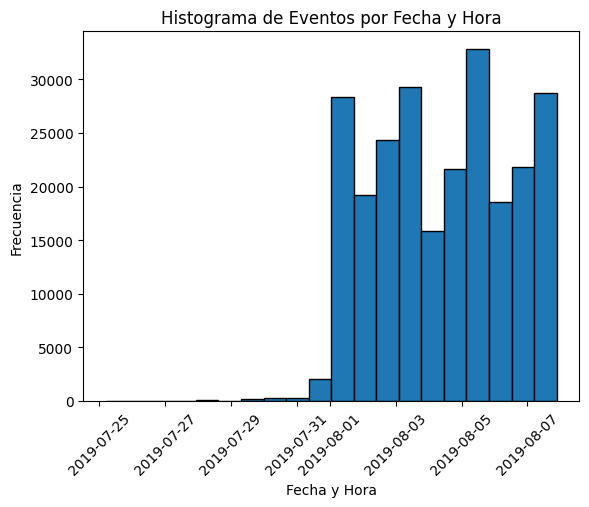

In [15]:
#Traza un histograma por fecha y hora
plt.hist(df['event_timestamp'], bins=20, edgecolor='black')

# Agregar títulos y etiquetas
plt.title('Histograma de Eventos por Fecha y Hora')
plt.xlabel('Fecha y Hora')
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mejor legibilidad
plt.show()

En este caso tenemos una asimetría positiva. La actividad de los usuarios es casi nula en julio y en agosto va de `15000` eventos para arriba.

Por lo anterior, no se puede tener seguridad de que los datos están igualmente completos para todo el periodo. Así que se van a ignorar los datos de julio y se van a considerar solo a partir de `agosto`. 

In [16]:
#Filtrar los datos par las fechas en las que están completos
limit_date = pd.to_datetime('2019-07-31')
df = df[df['event_timestamp'] > limit_date]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242917 entries, 797 to 244125
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       242917 non-null  object        
 1   device_id_hash   242917 non-null  int64         
 2   event_timestamp  242917 non-null  datetime64[ns]
 3   exp_id           242917 non-null  int64         
 4   date             242917 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.1+ MB


Se perdieron `796` datos al excluir los datos más antiguos.

### Verificar que se tienen usuarios y usuarias de los tres grupos experimentales

In [17]:
#Verificar los valores de número de experimento 
df['exp_id'].unique()

array([247, 248, 246])

Aún se cuenta con usuarios en los 3 grupos. 246 y 247 son los grupos de control, 248 es el grupo de prueba.

## Estudiar el embudo de eventos

### Frecuencia de suceso de los eventos

In [18]:
#Se agrupa para contar la frecuencia de sucesos
EventFreq = df.groupby('event_name')['event_name'].count().sort_values(ascending = False).reset_index(name='frequency')
EventFreq

,event_name,frequency
0,MainScreenAppear,118578
1,OffersScreenAppear,46707
2,CartScreenAppear,42560
3,PaymentScreenSuccessful,34058
4,Tutorial,1014


El evento que más ocurre es `pantalla principal`, seguido de `pantalla de ofertas`, seguido de `pantalla del carrito`, seguido de `pantalla de pago exitoso` y por último `tutorial`.

### Usuarios y usuarias que realizaron cada una de estas acciones

In [19]:
#Agrupar por EventName y contar usuarios únicos
events_by_users = df.groupby('event_name')['device_id_hash'].nunique().sort_values(ascending = False).reset_index(name='num_users')

#Calcular la proporción de usuarios que realizaron cada acción al menos una vez
total_users = df['device_id_hash'].nunique()
events_by_users['proportion_event'] = events_by_users['num_users'] / total_users

#Ordenar por el número de usuarios
events_by_users = events_by_users.sort_values(by='num_users', ascending=False)

events_by_users

,event_name,num_users,proportion_event
0,MainScreenAppear,7429,0.985017
1,OffersScreenAppear,4606,0.610713
2,CartScreenAppear,3742,0.496155
3,PaymentScreenSuccessful,3542,0.469637
4,Tutorial,845,0.112039


El `98%` de los usurios vio la `pantalla principal`, el `61%` la `pantalla de ofertas`, el `49%` la `pantalla del carrito`, el `46%` la `pantalla de pago exitoso` y por último el `11%` el `tutorial`.

### Proporción de usuarios y usuarias que pasan de una etapa a la siguiente

In [20]:
#Calcular las proporciones de usuarios entre etapas
events_by_users['proportion_by_stage'] = events_by_users['num_users'] / events_by_users['num_users'].shift(1)
events_by_users

,event_name,num_users,proportion_event,proportion_by_stage
0,MainScreenAppear,7429,0.985017,NaN
1,OffersScreenAppear,4606,0.610713,0.620003
2,CartScreenAppear,3742,0.496155,0.812419
3,PaymentScreenSuccessful,3542,0.469637,0.946553
4,Tutorial,845,0.112039,0.238566


Para `pantalla de ofertas`, solo un `62%` de usuarios pasaron de `pantalla principal` y para `tutorial`, solo un `23%` de usuarios pasaron de `pantalla de pago exitoso`. Sin embargo, es más relevante la caída de usuarios de `pantalla principal` a `pantalla de ofertas`, ya que los de `tutorial` ya hicieron una compra. 

El `94%` de usuarios que llegan al `carrito`, finalizan la compra. 

### Porcentaje de usuarios y usuarias hace todo el viaje desde su primer evento hasta el pago

In [21]:
#Calcular las proporciones de usuarios de la etapa 1 a la 5
events_by_users['proportion_final_stage'] = events_by_users['num_users'] / events_by_users['num_users'].shift(4)
events_by_users

,event_name,num_users,proportion_event,proportion_by_stage,proportion_final_stage
0,MainScreenAppear,7429,0.985017,NaN,NaN
1,OffersScreenAppear,4606,0.610713,0.620003,NaN
2,CartScreenAppear,3742,0.496155,0.812419,NaN
3,PaymentScreenSuccessful,3542,0.469637,0.946553,NaN
4,Tutorial,845,0.112039,0.238566,0.113743


El porcentaje de usurarios que pasan de `pantalla principal` a `tutorial` solo es del 11%.

## Estudiar los resultados del experimento

### Usuarios y usuarias hay en cada grupo

In [22]:
users_by_group = df.groupby('exp_id')['device_id_hash'].nunique().sort_values().reset_index(name='users_by_group')
users_by_group

,exp_id,users_by_group
0,246,2485
1,247,2517
2,248,2540


En los grupos de control `A` hay `2485` y `2517`, mientras que en el grupo de prueba `B` hay `2540`. Sería mejor si tosos los grupos tuvieran la misma cantidad de usuarios.

### Diferencia estadísticamente significativa entre las muestras 246 y 247

In [23]:
#Filtrar por grupos de control 246 y 247
a_246 = df[df['exp_id'] == 246]
b_247 = df[df['exp_id'] == 247]

#Comparar el número de eventos por usuario en cada grupo
events_per_user_246 = a_246.groupby('device_id_hash').size()
events_per_user_247 = b_247.groupby('device_id_hash').size()

#Nivel de significancia
alpha = 0.05

#Realizar prueba t de Student
result = st.ttest_ind(events_per_user_246, events_per_user_247, equal_var=False)

print('valor-p:', result.pvalue)

if result.pvalue < alpha:
    print("Se rechaza la hipótesis nula")
else:
    print("No se puede rechazar la hipótesis nula")

valor-p: 0.4514982465134316
No se puede rechazar la hipótesis nula


A partir de la prueba de hipótesis `no se puede rechazar la hipótesis nula`, es decir: No hay una diferencia estadísticamente significativa entre los `grupos de control`.

### Grupos de control

In [24]:
#Crear una función
def mann_whitney(df, event, A, B, alpha=0.05):
    
    #Filtrar por el evento
    event = df[df['event_name'] == event]
    
    #Filtrar grupos de control
    e_246 = event[event['exp_id'] == A]
    e_247 = event[event['exp_id'] == B]

    #Comparar el número de eventos por usuario en cada grupo
    users_246 = e_246.groupby('event_name')['device_id_hash'].nunique()
    users_247 = e_247.groupby('event_name')['device_id_hash'].nunique()

    print('Usuarios del grupo A:', users_246)
    print()
    print('Usuarios del grupo B:', users_247)
    print()

    #Calcular proporciones
    users_event = event.groupby('event_name')['device_id_hash'].nunique()
    proportion_a = (users_246 / users_event) * 100
    proportion_b = (users_247 / users_event) * 100
    print('Proporción grupo control A:', proportion_a)
    print()
    print('Proporción grupo control B:', proportion_b)
    print()

    #Realizar prueba de Mann-Whitney U
    result = st.mannwhitneyu(users_246.values, users_247.values)

    print('valor-p:', result.pvalue)
    print()

    if result.pvalue < alpha:
        print("Se rechaza la hipótesis nula")
    else:
        print("No se puede rechazar la hipótesis nula")

In [25]:
#Llamar a la función para el evento pantalla principal
mann_whitney(df, 'MainScreenAppear', 246, 247)

Usuarios del grupo A: event_name
MainScreenAppear    2452
Name: device_id_hash, dtype: int64

Usuarios del grupo B: event_name
MainScreenAppear    2479
Name: device_id_hash, dtype: int64

Proporción grupo control A: event_name
MainScreenAppear    33.005788
Name: device_id_hash, dtype: float64

Proporción grupo control B: event_name
MainScreenAppear    33.369229
Name: device_id_hash, dtype: float64

valor-p: 1.0

No se puede rechazar la hipótesis nula


Evento: `pantalla principal`
- La diferencia de usuarios de ambos grupos es muy mínimo. Sin embargo, hay más usuarios en el `grupo B`.
- La proporción de los grupos de control es `33%`.
- A partir de la prueba de hipótesis `no se puede rechazar la hipótesis nula`, es decir: No se puede decir que haya una diferencia estadísticamente significativa entre los grupos `A` y `B`.

In [26]:
#Llamar a la función para el evento pantalla ofertas
mann_whitney(df, 'OffersScreenAppear', 246, 247)

Usuarios del grupo A: event_name
OffersScreenAppear    1544
Name: device_id_hash, dtype: int64

Usuarios del grupo B: event_name
OffersScreenAppear    1526
Name: device_id_hash, dtype: int64

Proporción grupo control A: event_name
OffersScreenAppear    33.521494
Name: device_id_hash, dtype: float64

Proporción grupo control B: event_name
OffersScreenAppear    33.130699
Name: device_id_hash, dtype: float64

valor-p: 1.0

No se puede rechazar la hipótesis nula


Evento: `pantalla ofertas`
- La diferencia de usuarios de ambos grupos es muy mínimo. Sin embargo, hay más usuarios en el `grupo A`.
- La proporción de los grupos de control es `33%`.
- A partir de la prueba de hipótesis `no se puede rechazar la hipótesis nula`, es decir: No se puede decir que haya una diferencia estadísticamente significativa entre los grupos `A` y `B`.

In [27]:
#Llamar a la función para el evento pantalla del carrito
mann_whitney(df, 'CartScreenAppear', 246, 247)

Usuarios del grupo A: event_name
CartScreenAppear    1267
Name: device_id_hash, dtype: int64

Usuarios del grupo B: event_name
CartScreenAppear    1239
Name: device_id_hash, dtype: int64

Proporción grupo control A: event_name
CartScreenAppear    33.858899
Name: device_id_hash, dtype: float64

Proporción grupo control B: event_name
CartScreenAppear    33.110636
Name: device_id_hash, dtype: float64

valor-p: 1.0

No se puede rechazar la hipótesis nula


Evento: `pantalla del carrito`
- La diferencia de usuarios de ambos grupos es muy mínimo. Sin embargo, hay más usuarios en el `grupo A`.
- La proporción de los grupos de control es `33%`.
- A partir de la prueba de hipótesis `no se puede rechazar la hipótesis nula`, es decir: No se puede decir que haya una diferencia estadísticamente significativa entre los grupos `A` y `B`.

In [28]:
#Llamar a la función para el evento pantalla de pago exitoso
mann_whitney(df, 'PaymentScreenSuccessful', 246, 247)

Usuarios del grupo A: event_name
PaymentScreenSuccessful    1200
Name: device_id_hash, dtype: int64

Usuarios del grupo B: event_name
PaymentScreenSuccessful    1159
Name: device_id_hash, dtype: int64

Proporción grupo control A: event_name
PaymentScreenSuccessful    33.879164
Name: device_id_hash, dtype: float64

Proporción grupo control B: event_name
PaymentScreenSuccessful    32.721626
Name: device_id_hash, dtype: float64

valor-p: 1.0

No se puede rechazar la hipótesis nula


Evento: `pantalla de pago exitosos`
- La diferencia de usuarios de ambos grupos es muy mínimo. Sin embargo, hay más usuarios en el `grupo A`.
- La proporción de `grupo A` es `33.87%` y del `grupo B` es `32.72%`.
- A partir de la prueba de hipótesis `no se puede rechazar la hipótesis nula`, es decir: No se puede decir que haya una diferencia estadísticamente significativa entre los grupos `A` y `B`.

In [29]:
#Llamar a la función para el evento tutorial
mann_whitney(df, 'Tutorial', 246, 247)

Usuarios del grupo A: event_name
Tutorial    278
Name: device_id_hash, dtype: int64

Usuarios del grupo B: event_name
Tutorial    285
Name: device_id_hash, dtype: int64

Proporción grupo control A: event_name
Tutorial    32.899408
Name: device_id_hash, dtype: float64

Proporción grupo control B: event_name
Tutorial    33.727811
Name: device_id_hash, dtype: float64

valor-p: 1.0

No se puede rechazar la hipótesis nula


Evento: `tutorial`
- La diferencia de usuarios de ambos grupos es muy mínimo. Sin embargo, hay más usuarios en el `grupo B`.
- La proporción del `grupo A` es `32.89%` y del `grupo B` es `33.72%`.
- A partir de la prueba de hipótesis `no se puede rechazar la hipótesis nula`, es decir: No se puede decir que haya una diferencia estadísticamente significativa entre los grupos `A` y `B`.

### Grupo de prueba

#### Grupo A y grupo C

In [30]:
#Llamar a la función para el evento pantalla principal (Grupo A y C)
mann_whitney(df, 'MainScreenAppear', 246, 248)

Usuarios del grupo A: event_name
MainScreenAppear    2452
Name: device_id_hash, dtype: int64

Usuarios del grupo B: event_name
MainScreenAppear    2498
Name: device_id_hash, dtype: int64

Proporción grupo control A: event_name
MainScreenAppear    33.005788
Name: device_id_hash, dtype: float64

Proporción grupo control B: event_name
MainScreenAppear    33.624983
Name: device_id_hash, dtype: float64

valor-p: 1.0

No se puede rechazar la hipótesis nula


Evento: `pantalla principal`

- La diferencia de usuarios de ambos grupos es muy mínimo. Sin embargo, hay más usuarios en el `grupo C`.
- La proporción del `grupo A` y `grupo C` es `33%`.
- A partir de la prueba de hipótesis `no se puede rechazar la hipótesis nula`, es decir: No se puede decir que haya una diferencia estadísticamente significativa entre los grupos `A` y `C`.

In [31]:
#Llamar a la función para el evento pantalla principal (Grupo A y C)
mann_whitney(df, 'OffersScreenAppear', 246, 248)

Usuarios del grupo A: event_name
OffersScreenAppear    1544
Name: device_id_hash, dtype: int64

Usuarios del grupo B: event_name
OffersScreenAppear    1536
Name: device_id_hash, dtype: int64

Proporción grupo control A: event_name
OffersScreenAppear    33.521494
Name: device_id_hash, dtype: float64

Proporción grupo control B: event_name
OffersScreenAppear    33.347807
Name: device_id_hash, dtype: float64

valor-p: 1.0

No se puede rechazar la hipótesis nula


Evento: `pantalla de ofertas`

- La diferencia de usuarios de ambos grupos es muy mínimo. Sin embargo, hay más usuarios en el `grupo A`.
- La proporción del `grupo A` y `grupo C` es `33%`.
- A partir de la prueba de hipótesis `no se puede rechazar la hipótesis nula`, es decir: No se puede decir que haya una diferencia estadísticamente significativa entre los grupos `A` y `C`.

In [32]:
#Llamar a la función para el evento pantalla principal (Grupo A y C)
mann_whitney(df, 'CartScreenAppear', 246, 248)

Usuarios del grupo A: event_name
CartScreenAppear    1267
Name: device_id_hash, dtype: int64

Usuarios del grupo B: event_name
CartScreenAppear    1236
Name: device_id_hash, dtype: int64

Proporción grupo control A: event_name
CartScreenAppear    33.858899
Name: device_id_hash, dtype: float64

Proporción grupo control B: event_name
CartScreenAppear    33.030465
Name: device_id_hash, dtype: float64

valor-p: 1.0

No se puede rechazar la hipótesis nula


Evento: `pantalla del carrito`

- La diferencia de usuarios de ambos grupos es muy mínimo. Sin embargo, hay más usuarios en el `grupo A`.
- La proporción del `grupo A` y `grupo C` es `33%`.
- A partir de la prueba de hipótesis `no se puede rechazar la hipótesis nula`, es decir: No se puede decir que haya una diferencia estadísticamente significativa entre los grupos `A` y `C`.

In [33]:
#Llamar a la función para el evento pantalla principal (Grupo A y C)
mann_whitney(df, 'PaymentScreenSuccessful', 246, 248)

Usuarios del grupo A: event_name
PaymentScreenSuccessful    1200
Name: device_id_hash, dtype: int64

Usuarios del grupo B: event_name
PaymentScreenSuccessful    1183
Name: device_id_hash, dtype: int64

Proporción grupo control A: event_name
PaymentScreenSuccessful    33.879164
Name: device_id_hash, dtype: float64

Proporción grupo control B: event_name
PaymentScreenSuccessful    33.399209
Name: device_id_hash, dtype: float64

valor-p: 1.0

No se puede rechazar la hipótesis nula


Evento: `pantalla de pago exitoso`

- La diferencia de usuarios de ambos grupos es muy mínimo. Sin embargo, hay más usuarios en el `grupo A`.
- La proporción del `grupo A` y `grupo C` es `33%`.
- A partir de la prueba de hipótesis `no se puede rechazar la hipótesis nula`, es decir: No se puede decir que haya una diferencia estadísticamente significativa entre los grupos `A` y `C`.

In [34]:
#Llamar a la función para el evento pantalla principal (Grupo A y C)
mann_whitney(df, 'Tutorial', 246, 248)

Usuarios del grupo A: event_name
Tutorial    278
Name: device_id_hash, dtype: int64

Usuarios del grupo B: event_name
Tutorial    282
Name: device_id_hash, dtype: int64

Proporción grupo control A: event_name
Tutorial    32.899408
Name: device_id_hash, dtype: float64

Proporción grupo control B: event_name
Tutorial    33.372781
Name: device_id_hash, dtype: float64

valor-p: 1.0

No se puede rechazar la hipótesis nula


Evento: `tutorial`

- La diferencia de usuarios de ambos grupos es muy mínimo. Sin embargo, hay más usuarios en el `grupo C`.
- La proporción del `grupo A` es `32.89%` y del `grupo C` es `33%`.
- A partir de la prueba de hipótesis `no se puede rechazar la hipótesis nula`, es decir: No se puede decir que haya una diferencia estadísticamente significativa entre los grupos `A` y `C`.

#### Grupos B y grupo C

In [35]:
#Llamar a la función para el evento pantalla principal (Grupo B y C)
mann_whitney(df, 'MainScreenAppear', 246, 248)

Usuarios del grupo A: event_name
MainScreenAppear    2452
Name: device_id_hash, dtype: int64

Usuarios del grupo B: event_name
MainScreenAppear    2498
Name: device_id_hash, dtype: int64

Proporción grupo control A: event_name
MainScreenAppear    33.005788
Name: device_id_hash, dtype: float64

Proporción grupo control B: event_name
MainScreenAppear    33.624983
Name: device_id_hash, dtype: float64

valor-p: 1.0

No se puede rechazar la hipótesis nula


Evento: `pantalla princiapl`

- La diferencia de usuarios de ambos grupos es muy mínimo. Sin embargo, hay más usuarios en el `grupo C`.
- La proporción del `grupo B` y `grupo C` es `33%`.
- A partir de la prueba de hipótesis `no se puede rechazar la hipótesis nula`, es decir: No se puede decir que haya una diferencia estadísticamente significativa entre los grupos `B` y `C`.

In [36]:
#Llamar a la función para el evento pantalla de ofertas (Grupo B y C)
mann_whitney(df, 'OffersScreenAppear', 246, 248)

Usuarios del grupo A: event_name
OffersScreenAppear    1544
Name: device_id_hash, dtype: int64

Usuarios del grupo B: event_name
OffersScreenAppear    1536
Name: device_id_hash, dtype: int64

Proporción grupo control A: event_name
OffersScreenAppear    33.521494
Name: device_id_hash, dtype: float64

Proporción grupo control B: event_name
OffersScreenAppear    33.347807
Name: device_id_hash, dtype: float64

valor-p: 1.0

No se puede rechazar la hipótesis nula


Evento: `pantalla de ofertas`

- La diferencia de usuarios de ambos grupos es muy mínimo. Sin embargo, hay más usuarios en el `grupo B`.
- La proporción del `grupo B` y `grupo C` es `33%`.
- A partir de la prueba de hipótesis `no se puede rechazar la hipótesis nula`, es decir: No se puede decir que haya una diferencia estadísticamente significativa entre los grupos `B` y `C`.

In [37]:
#Llamar a la función para el evento pantalla del carrito (Grupo B y C)
mann_whitney(df, 'CartScreenAppear', 246, 248)

Usuarios del grupo A: event_name
CartScreenAppear    1267
Name: device_id_hash, dtype: int64

Usuarios del grupo B: event_name
CartScreenAppear    1236
Name: device_id_hash, dtype: int64

Proporción grupo control A: event_name
CartScreenAppear    33.858899
Name: device_id_hash, dtype: float64

Proporción grupo control B: event_name
CartScreenAppear    33.030465
Name: device_id_hash, dtype: float64

valor-p: 1.0

No se puede rechazar la hipótesis nula


Evento: `pantalla del carrito`

- La diferencia de usuarios de ambos grupos es muy mínimo. Sin embargo, hay más usuarios en el `grupo B`.
- La proporción del `grupo B` y `grupo C` es `33%`.
- A partir de la prueba de hipótesis `no se puede rechazar la hipótesis nula`, es decir: No se puede decir que haya una diferencia estadísticamente significativa entre los grupos `B` y `C`.

In [38]:
#Llamar a la función para el evento pantalla de pago exitoso (Grupo B y C)
mann_whitney(df, 'PaymentScreenSuccessful', 246, 248)

Usuarios del grupo A: event_name
PaymentScreenSuccessful    1200
Name: device_id_hash, dtype: int64

Usuarios del grupo B: event_name
PaymentScreenSuccessful    1183
Name: device_id_hash, dtype: int64

Proporción grupo control A: event_name
PaymentScreenSuccessful    33.879164
Name: device_id_hash, dtype: float64

Proporción grupo control B: event_name
PaymentScreenSuccessful    33.399209
Name: device_id_hash, dtype: float64

valor-p: 1.0

No se puede rechazar la hipótesis nula


Evento: `pantalla de pago exitoso`

- La diferencia de usuarios de ambos grupos es muy mínimo. Sin embargo, hay más usuarios en el `grupo B`.
- La proporción del `grupo B` y `grupo C` es `33%`.
- A partir de la prueba de hipótesis `no se puede rechazar la hipótesis nula`, es decir: No se puede decir que haya una diferencia estadísticamente significativa entre los grupos `B` y `C`.

In [39]:
#Llamar a la función para el evento tutorial (Grupo B y C)
mann_whitney(df, 'Tutorial', 246, 248)

Usuarios del grupo A: event_name
Tutorial    278
Name: device_id_hash, dtype: int64

Usuarios del grupo B: event_name
Tutorial    282
Name: device_id_hash, dtype: int64

Proporción grupo control A: event_name
Tutorial    32.899408
Name: device_id_hash, dtype: float64

Proporción grupo control B: event_name
Tutorial    33.372781
Name: device_id_hash, dtype: float64

valor-p: 1.0

No se puede rechazar la hipótesis nula


Evento: `tutorial`

- La diferencia de usuarios de ambos grupos es muy mínimo. Sin embargo, hay más usuarios en el `grupo C`.
- La proporción del `grupo B` es `32.89%` y del `grupo C` es `33.37%`.
- A partir de la prueba de hipótesis `no se puede rechazar la hipótesis nula`, es decir: No se puede decir que haya una diferencia estadísticamente significativa entre los grupos `B` y `C`.

# Conclusiones

Resultados:
- Entre los grupos `A y C`, y entre `B y C`, la diferencia en la cantidad de usuarios es casi insignificante.
- Ambas proporciones son del `33%` aproximadamente, esto refuerza la idea de que no hay diferencias significativas en el comportamiento de los usuarios entre los grupos
- No se encontró evidencia suficiente para afirmar que hay diferencias significativas entre los grupos.

Conclusiones: 
- La falta de diferencias significativas entre los `grupos A y B` sugiere que los grupos de control son consistentes y fiables. Esto es fundamental para asegurar que los datos recogidos son representativos.
- Dado que el `grupo de prueba` no mostró una mejora en comparación con los `grupos de control`, se puede concluir que las modificaciones o cambios implementados no tuvieron un impacto positivo en la participación de los usuarios.
- El resultado de `no rechazar la hipótesis nula` indica que no hay evidencia de que los cambios en el `grupo C` hayan influido en el comportamiento de los usuarios. Esto es relevante para decisiones futuras sobre si implementar o no el cambio evaluado.

La ausencia de diferencias significativas sugiere que el cambio propuesto no tiene un impacto en la participación de los usuarios, lo que lleva a la necesidad de reconsiderar las modificaciones y explorar nuevas hipótesis en el futuro.